# Generate QC:RSFC plots

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nibabel as nib
import pandas as pd
import statsmodels.api as sm
from nilearn import input_data, datasets
from scipy import stats
from scipy.spatial.distance import pdist, squareform

sns.set_style('whitegrid')

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def fast_pearson(X, y):
    """Fast correlations between y and each row of X.
    From http://qr.ae/TU1B9C
    """
    assert len(X.shape) == 2
    assert len(y.shape) == 1
    assert y.shape[0] == X.shape[1]
    y_bar = np.mean(y)
    y_intermediate = y - y_bar
    X_bar = np.mean(X, axis=1)[:, np.newaxis]
    X_intermediate = X - X_bar
    nums = X_intermediate.dot(y_intermediate)
    y_sq = np.sum(np.square(y_intermediate))
    X_sqs = np.sum(np.square(X_intermediate), axis=1)
    denoms = np.sqrt(y_sq * X_sqs)
    pearsons = nums / denoms
    return pearsons

def get_fd(motion):
    # assuming rotations in degrees
    motion[:, :3] = motion[:, :3] * (np.pi/180.) * 50
    motion = np.vstack((np.array([[0, 0, 0, 0, 0, 0]]),
                        np.diff(motion, axis=0)))
    fd = np.sum(np.abs(motion), axis=1)
    return fd

def qcrsfc(imgs, qc, masker):
    assert len(imgs) == len(qc)
    n_subjects = len(imgs)
    idx = np.triu_indices(masker.seeds.shape[0], k=1)
    corr_mats = np.zeros((n_subjects, len(idx[0])))
    for i in range(n_subjects):
        raw_corrs = np.corrcoef(masker.fit_transform(imgs[i]).T)
        corr_mats[i, :] = raw_corrs[idx]
    
    qcrsfc_rs = fast_pearson(corr_mats.T, qc)
    return qcrsfc_rs

In [3]:
n_subjects = 31
power = datasets.fetch_coords_power_2011()
coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T
idx = np.triu_indices(coords.shape[0], k=1)
dists = squareform(pdist(coords))
dists = dists[idx]

data = datasets.fetch_adhd(n_subjects=n_subjects)
img = nib.load(data.func[0])
tr = img.header.get_zooms()[-1]
spheres_masker = input_data.NiftiSpheresMasker(
    seeds=coords, radius=5., t_r=tr,
    smoothing_fwhm=4, detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01)

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nilearn/datasets/func.py:501: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


In [4]:
fd_all = np.zeros(n_subjects)
imgs = [nib.load(f) for f in data.func]
for i in range(n_subjects):
    df = pd.read_csv(data.confounds[i], sep='\t')
    motion = df[['motion-pitch', 'motion-roll', 'motion-yaw',
                 'motion-x', 'motion-y', 'motion-z']].values
    fd_all[i] = np.mean(get_fd(motion))

qcrsfc_rs = qcrsfc(imgs, fd_all, spheres_masker)

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


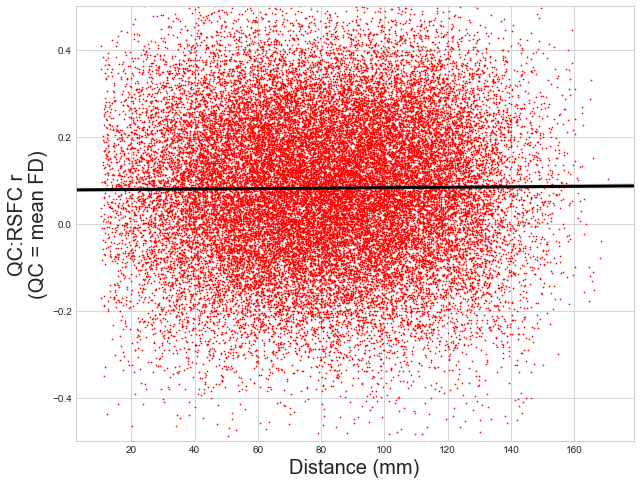

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.regplot(dists, qcrsfc_rs, ax=ax, scatter=True, #lowess=True,
            line_kws={'color': 'black', 'linewidth': 3},
            scatter_kws={'color': 'red', 's': 0.5, 'alpha': 1})
ax.set_xlabel('Distance (mm)', fontsize=20)
ax.set_ylabel('QC:RSFC r\n(QC = mean FD)', fontsize=20)
ax.set_ylim(-0.5, 0.5)
fig.show()

In [6]:
X = sm.add_constant(dists, prepend=False)
mod = sm.OLS(qcrsfc_rs, X)
res = mod.fit()
m, b = res.params
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.926
Date:                Sat, 21 Apr 2018   Prob (F-statistic):             0.0871
Time:                        16:43:18   Log-Likelihood:                 11440.
No. Observations:               34716   AIC:                        -2.288e+04
Df Residuals:                   34714   BIC:                        -2.286e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          5.217e-05   3.05e-05      1.711      0.0